# Multilingual Language Identification with N-gram Fingerprints

This notebook implements a language identification method from scratch, based on character n-gram frequency profiles.  
It follows the statistical framework of Cavnar & Trenkle (1994) N-Gram-Based Text Categorization. Implemented manually in Python.

We use:
- [`datasets`](https://huggingface.co/docs/datasets) for multilingual text samples  
- `Counter` from `collections` for n-gram counting  
- `math` and `re` for similarity and preprocessing  
- `matplotlib` for visualization  

Self-contained prototype — no pre-trained LangID models used.


In [1]:
# Setup
# !pip install datasets tqdm matplotlib
# Imports
from datasets import load_dataset
from collections import Counter
import re
import math
from tqdm import tqdm
import matplotlib.pyplot as plt


### Step 1. Load Multilingual Data
We’ll sample small portions of the tatoeba dataset for several languages.


In [ ]:

dataset = {}  # lang -> list of sentences
tatoeba = load_dataset("tatoeba")

configs = list(tatoeba.keys())

# auto-detect language codes
languages = set()
for cfg in configs:
    langs = list(tatoeba[cfg]['train'][0]['translation'].keys())
    languages.update(langs)
languages = sorted(list(languages))

def extract_lang(lang, n=200):
    sentences = []
    for cfg in configs:
        data = tatoeba[cfg]['train']
        for row in data:
            if lang in row["translation"]:
                sentences.append(row["translation"][lang])
            if len(sentences) >= n:
                break
        if len(sentences) >= n:
            break
    return sentences

for lang in languages:
    dataset[lang] = extract_lang(lang)


In [47]:
import pandas as pd

pd.DataFrame(dataset)

,en,eo,es,fr,gl,mr,nl,pt,ru
0,Today is June 18th and it is Muiriel's birthday!,Ĉu vi dezirus havi tason da kafo?,¡Intentemos algo!,Pour une fois dans ma vie je fais un bon geste...,Que andas a facer?,आज १८ जून आहे व आज म्यूरिएलचा वाढदिवस आहे!,Wilt u een kopje koffie?,Vamos tentar alguma coisa!,Один раз в жизни я делаю хорошее дело... И оно...
1,Muiriel is 20 now.,Ĉu vi volas tason da kafo?,¡Intentemos algo!,Lorsqu'il a demandé qui avait cassé la fenêtre...,"Feliz aniversario, Muiriel!",म्यूरिएल आता २० वर्षांची आहे.,Wilt u een kopje koffie?,Vamos tentar algo!,"Когда он спросил, кто разбил окно, все мальчик..."
2,"The password is ""Muiriel"".",Ĉu vi deziras tason da kafo?,Tengo que irme a dormir.,Je ne supporte pas ce type.,"O contrasinal é ""Muiriel"".","पासवर्ड ""Muiriel"" आहे.",Wilt u een kopje koffie?,Preciso ir dormir.,Я не переношу этого типа.
3,I will be back soon.,Kiomaĝa vi estas?,Tengo que irme a dormir.,Ne tenez aucun compte de ce qu'il dit.,A educación neste mundo decepcióname.,मी लवकरच परत येईन.,Hoe oud bent u?,Tenho que ir dormir.,Не обращайте внимания на его слова.
4,I will be back soon.,Kiom da jaroj vi havas?,Tengo que irme a dormir.,Essayons quelque chose !,Daquela temos un problema...,मी लवकरच परतेन.,Hoe oud bent u?,Tenho de dormir.,Давайте что-нибудь попробуем!
...,...,...,...,...,...,...,...,...,...
195,I'm going to take a bath.,Mi montros kelkajn fotojn al vi.,Me llamo Jack.,Félicitations.,El só gaña uns 50 dólares á semana.,मी अंघोळ करणार आहे.,Ik zal jullie wat foto's laten zien.,Meu nome é Jack.,Мои поздравления.
196,I'm going to take a bath.,Nun mi memoras.,Me gusta mucho.,Je ne veux pas attendre aussi longtemps.,El cortou varias pólas do carballo.,मी अंघोळ करायला जातोय.,Nu weet ik het weer.,Eu gosto muito disso.,Я не хочу ждать так долго.
197,I'm going to take a bath.,Nun mi memoras.,Me gusta mucho.,Je ne veux pas attendre aussi longtemps.,Que alto é el!,मी अंघोळ करायला जातेय.,Ik herinner het me nu.,Gosto muito dela.,Мне не хочется так долго ждать.
198,We left by train.,Mi ne parolas la japanan.,Me gusta mucho.,Je ne veux pas attendre aussi longtemps.,O equipo perdedor deixou o estadio de vagar.,आम्ही ट्रेनने निघालो.,Ik spreek geen Japans.,Gosto muito dele.,Я не хочу так долго ждать.


In [ ]:
import re
from collections import Counter
import math

def clean_text(text):
    # Unicode-safe cleaner for all scripts
    return re.sub(r"[^\w\s]", "", text.lower())

def extract_ngrams(text, n=3):
    text = clean_text(text)
    return [text[i:i+n] for i in range(len(text) - n + 1)]

def build_profile(texts, n=3):
    counter = Counter()
    for t in texts:
        counter.update(extract_ngrams(t, n))
    total = sum(counter.values())
    return {k: v/total for k, v in counter.items()} if total > 0 else {}
# Each profile is a probability distribution over character n-grams.

### Step 3. Train Language Profiles
We create an n-gram frequency distribution for each language.


In [ ]:
test_size = 30

# split
train_texts = {lang: dataset[lang][test_size:] for lang in languages}
test_texts  = {lang: test_texts[lang] for lang in languages}

profiles = {lang: build_profile(train_texts[lang]) for lang in languages}
print("Profiles built for:", list(profiles.keys()))


Profiles built for: ['en', 'eo', 'es', 'fr', 'gl', 'mr', 'nl', 'pt', 'ru']


### 4 — Cosine similarity & prediction

In [52]:
### 4 — Cosine similarity & prediction
def cosine_similarity(p1, p2):
    keys = set(p1.keys()) | set(p2.keys())
    v1 = [p1.get(k, 0) for k in keys]
    v2 = [p2.get(k, 0) for k in keys]
    dot = sum(a*b for a,b in zip(v1, v2))
    mag1 = math.sqrt(sum(a*a for a in v1))
    mag2 = math.sqrt(sum(b*b for b in v2))
    return dot/(mag1*mag2) if mag1 and mag2 else 0.0

def identify_language(text):
    profile = build_profile([text])
    sims = {lang: cosine_similarity(profile, profiles[lang]) for lang in languages}
    return max(sims, key=sims.get), sims

# evaluate on true held-out test set
correct = 0

for lang in languages:
    for sent in test_texts[lang]:
        pred, _ = identify_language(sent)
        correct += (pred == lang)

accuracy = correct / (len(languages) * test_size)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 88.15%


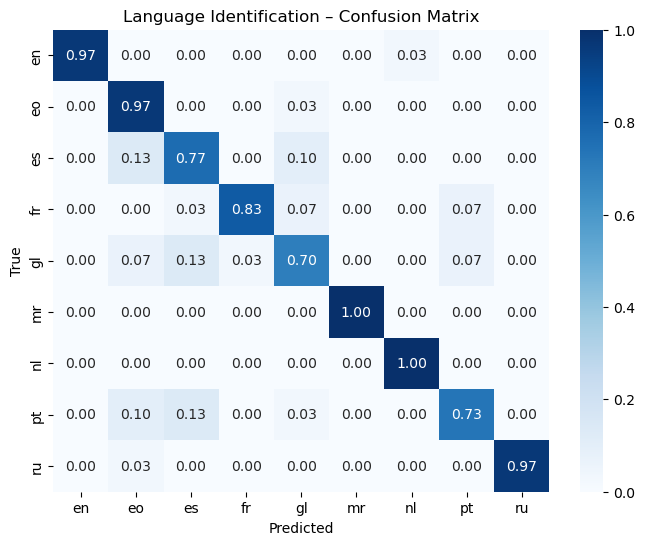

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Build confusion matrix ===
num_langs = len(languages)
conf_matrix = np.zeros((num_langs, num_langs))

test_size = 30  # same as your evaluation

for i, lang in enumerate(languages):
    for sent in test_texts[lang]:
        pred, _ = identify_language(sent)
        j = languages.index(pred)
        conf_matrix[i, j] += 1

# normalize rows to percentages
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# === Plot confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f",
            xticklabels=languages, yticklabels=languages, cmap="Blues")

plt.title("Language Identification – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


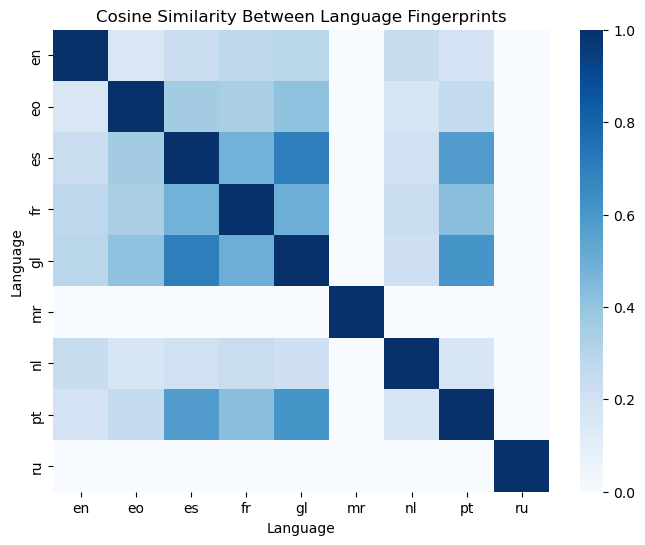

In [57]:
# === Compute full pairwise similarity matrix ===
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_langs = len(languages)
sim_matrix = np.zeros((num_langs, num_langs))

for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        sim_matrix[i, j] = cosine_similarity(profiles[lang1], profiles[lang2])

# === Visualize ===
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix,
            xticklabels=languages,
            yticklabels=languages,
            cmap="Blues",
            annot=False)

plt.title("Cosine Similarity Between Language Fingerprints")
plt.xlabel("Language")
plt.ylabel("Language")
plt.show()
